In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl

from konlpy.tag import Okt
from konlpy.tag import Twitter
from soynlp.tokenizer import MaxScoreTokenizer
from soynlp.normalizer import *
import re
import sentencepiece as spm # 가장 성능이 좋았음
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
#import wandb
#from wandb.keras import WandbCallback

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


# 데이터

In [2]:
train_data_path ="~/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head(10)

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
5,5,직장 내 괴롭힘 대화,나 이틀뒤에 가나다 음식점 예약좀 해줘. 저녁7시로.\n가나다 음식점이요.?\n응....
6,6,기타 괴롭힘 대화,35번 손님 아이스커피 두잔나왔습니다\n아이스커피? \n네 맛있게드세요\n저기요 아...
7,7,기타 괴롭힘 대화,경비아저씨 내차에 경고장 붙였어요?\n내가 여기 몇년째 사는데 아직도 내차인줄 모르...
8,8,기타 괴롭힘 대화,이거 할인 된다면서요\n 확인해보겠습니다\n 아까 저 시람은 할인 해주던데\n 네 ...
9,9,갈취 대화,자네 세금계산서 보내준 거 메일이랑 수치가 다르던데?\n그게.\n얼마나 해먹었어? ...


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           3950 non-null   int64 
 1   class         3950 non-null   object
 2   conversation  3950 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.7+ KB


**모델의 학습을 위해서 각 클래스당, 숫자를 할당하는 encoding 이 필요해보임 **

In [4]:
train_data['class'].value_counts()

기타 괴롭힘 대화      1094
갈취 대화           981
직장 내 괴롭힘 대화     979
협박 대화           896
Name: class, dtype: int64

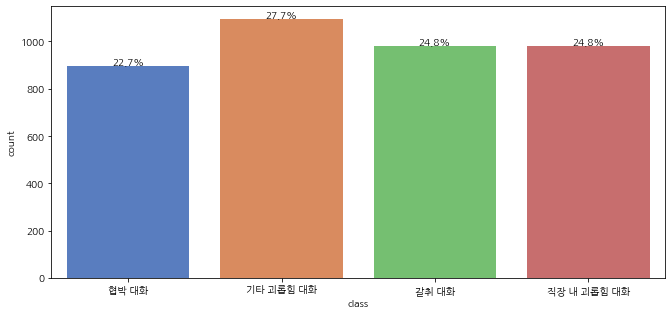

In [5]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11, 5)

# plot 그림
sns.countplot(x='class', data=train_data, palette='muted') 

# 퍼센트 표기
total = len(train_data['class'])
for p in axe.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axe.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

***클래스간의 약간의 차이가 있기는 하나, 큰 차이를 보이지 않음***

In [6]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']

label_encoder = LabelEncoder()
label_encoder.fit(CLASS_NAMES)
encoded_classnames = label_encoder.transform(train_data['class'])
print("Original classnames:", CLASS_NAMES)
print("Encoded classnames:", encoded_classnames)

# inverse_transform 메서드로 역변환
decoded_classnames = label_encoder.inverse_transform(encoded_classnames)
print("Decoded classnames:", decoded_classnames)

Original classnames: ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']
Encoded classnames: [3 3 1 ... 2 0 2]
Decoded classnames: ['협박 대화' '협박 대화' '기타 괴롭힘 대화' ... '직장 내 괴롭힘 대화' '갈취 대화' '직장 내 괴롭힘 대화']


***label encoding***    

원했던 label encoding 방식은 아래와 같았으나, LabelEncoder()를 사용시에 label encoding이 잘 못 되어 있는 것을 알게 됨.   
이는 초기에 학습 시켰던 모델의 submission 결과(0.295)가 낮게 나온 원인이었음.   

> class 0: 협박 대화  
> class 1: 갈취 대화  
> class 2: 직장 내 괴롭힘 대화  
> class 3: 기타 괴롭힘 대화

아래와 같은 방식을 label encoding을 진행함.

In [7]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']

class_dict = {}
for idx, class_name in enumerate(CLASS_NAMES):
    class_dict[class_name] = idx

train_data['class'] = train_data['class'].apply(lambda s: class_dict[s])

corpus = train_data["conversation"]

In [8]:
corpus.head()

0    지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1    길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2    너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3    어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4    저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
Name: conversation, dtype: object

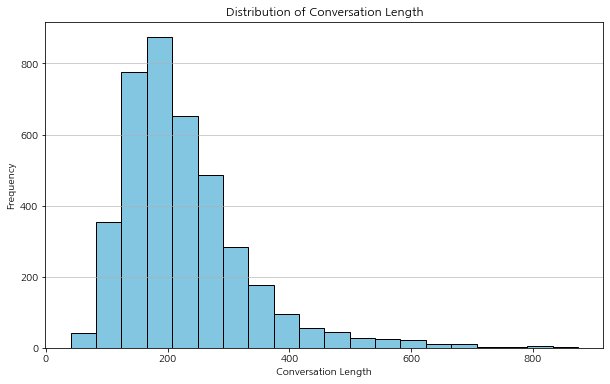

In [9]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

# 대화의 길이 계산
train_data['conversation_length'] = train_data['conversation'].apply(lambda x: len(x))

# Seaborn의 muted 팔레트와 비슷한 색상 생성
custom_palette = sns.color_palette("muted")

# 대화 길이 시각화
plt.figure(figsize=(10, 6))
plt.hist(train_data['conversation_length'], bins=20, color=custom_palette[9], edgecolor='black')  
plt.xlabel('Conversation Length')
plt.ylabel('Frequency')
plt.title('Distribution of Conversation Length')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [10]:
train_data.head()

,idx,class,conversation,conversation_length
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,242
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,188
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,218
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,115
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,460


In [11]:
train_data['conversation_length']

0       242
1       188
2       218
3       115
4       460
       ... 
3945    233
3946    223
3947    301
3948    225
3949    140
Name: conversation_length, Length: 3950, dtype: int64

In [12]:
np.min(train_data['conversation_length'])

41

문장의 최단 길이: 41
문장의 최장 길이: 874
문장의 평균 길이: 226


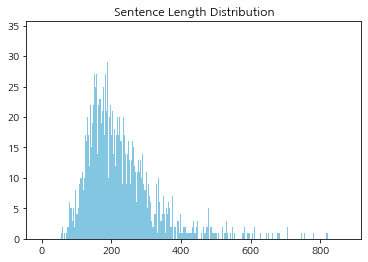

In [13]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_data['conversation_length']:
    length = sen
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data['conversation_length']))

sentence_length = np.zeros((max_len), dtype=int)

for sen in train_data['conversation_length']:
    sentence_length[sen-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0, color = custom_palette[9])
plt.title("Sentence Length Distribution")
plt.show()

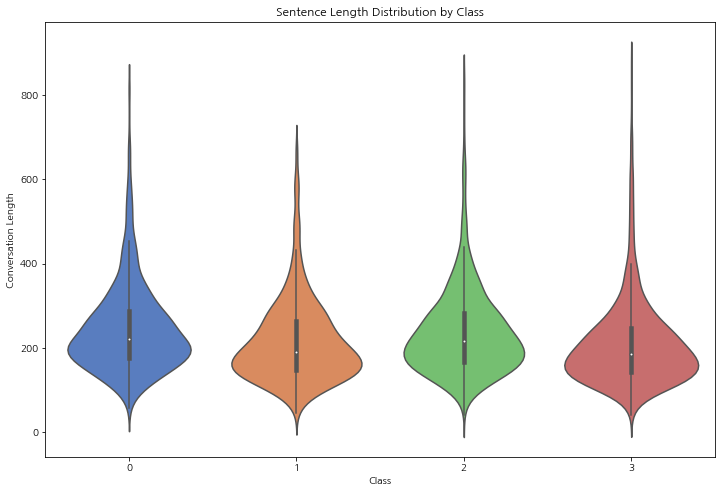

In [14]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

# 대화의 길이 계산
train_data['conversation_length'] = train_data['conversation'].apply(lambda x: len(x))

# 각 클래스별로 데이터 나누기
class_labels = train_data['class'].unique()

# Seaborn의 muted 팔레트와 비슷한 색상 생성
custom_palette = sns.color_palette("muted")

# 클래스별 violinplot 그리기
plt.figure(figsize=(12, 8))
sns.violinplot(x='class', y='conversation_length', data=train_data, palette=custom_palette, split=True)
plt.title("Sentence Length Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Conversation Length")
plt.show()

In [15]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(train_data['conversation'], 41)

일다했나
아니오
빨리해
네
언제할꺼야
내일까지
오늘끝내
안돼요
밤새서해
네
안녕
네?
무시해?
아뇨
이쁘네
네?
이쁘다구
아 네
오늘 시간되니?
아뇨


# 전처리

In [16]:
def preprocess_sentence(sentence):
    emoticon_normalize(sentence) # soynlp 
    repeat_normalize(sentence) # soynlp
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 문장 내의 구두점 앞뒤에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 여러 개의 공백을 하나의 공백으로 축소
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence) #  한글, 영문자와 구두점(. ? ! ,) 이외의 모든 문자를 공백으로 대체

    sentence = sentence.strip()
    
    return sentence #전처리된 문장을 반환  

In [17]:
corpus = []
for sentence in train_data['conversation']:
    corpus.append(preprocess_sentence(sentence))

In [18]:
corpus

['지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 ? 진짜 죽여버리고 싶게 . 정말 잘못했습니다 . 너가 선택해 . 너가 죽을래 네 가족을 죽여줄까 . 죄송합니다 . 정말 잘못했습니다 . 너에게는 선택권이 없어 . 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야 . 선택 못하겠습니다 . 한번만 도와주세요 . 그냥 다 죽여버려야겠군 . 이의 없지 ? 제발 도와주세요 .',
 '길동경찰서입니다 . 시 분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 한번만 더 얘기한다 . 장난전화 걸지 마시죠 . 시 분 마트에 폭발물이 터지면 다 죽는거야 . 장난전화는 업무방해죄에 해당됩니다 . 판단은 너에게 달려있다 . 길동경찰서에도 폭발물 터지면 꽤나 재미있겠지 . 선생님 진정하세요 . 난 이야기했어 . 경고했다는 말이야 .',
 '너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 재미없어 . 지영아 너가 키 이지 ? 그럼 재는 도 안돼는거네 ? 너 군대도 안가고 좋겠다 . 니들이 나 작은데 보태준거 있냐 ? 난쟁이들도 장가가고하던데 . 너도 희망을 가져봐 더이상 하지마라 . 그 키크는 수술도 있대잖아 ? 니네 엄마는 그거 안해주디 ? 나람 해줬어 . 저 키로 어찌살아 . 제발 그만 괴롭히라고 !',
 '어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ? 얘 돈 좀 있나봐 아니에요 . 돈 없어요 뒤져서 나오면 넌 죽는다 오늘 피시방 콜 ? 콜 . 마지막 기회다 . 있는거 다 내놔 정말 없어요',
 '저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에 발라보실래요 ? 아 진짜요 ? 안 그래도 선크림 필요해서 알아보던 중인데 한 번 발라 볼게요 ! 여기 한 번 발라보세요 . 진짜 성분도 좋고 다 좋아요 . 음 . 성분이 좋다고 하셔서 좋은거 같기는 한데 제 피부에 맞지 않나봐요 . 피부가 따끔거리네

In [19]:
check_sentence_with_length(corpus, 41)

일다했나 아니오 빨리해 네 언제할꺼야 내일까지 오늘끝내 안돼요 밤새서해 네


# 토큰화

In [20]:
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    with open(f"{lang}_corpus.txt", "w") as f:
        for sentence in corpus:
            f.write(sentence + "\n")
    
    model_prefix = f"{lang}_tokenizer"
    
    spm.SentencePieceTrainer.train(
        f"--input={lang}_corpus.txt --model_prefix={model_prefix} --vocab_size={vocab_size}" + 
        f" --pad_id={pad_id} --pad_piece=[PAD]" +
        f" --unk_id={unk_id} --unk_piece=[UNK]" +
        f" --bos_id={bos_id} --bos_piece=[BOS]" +
        f" --eos_id={eos_id} --eos_piece=[EOS]" +
        " --model_type=unigram --max_sentence_length=999999")

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{model_prefix}.model")
    
    return tokenizer

In [21]:
SRC_VOCAB_SIZE = 20000
tokenizer = generate_tokenizer(corpus, SRC_VOCAB_SIZE, 'ko')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=ko_corpus.txt --model_prefix=ko_tokenizer --vocab_size=20000 --pad_id=0 --pad_piece=[PAD] --unk_id=3 --unk_piece=[UNK] --bos_id=1 --bos_piece=[BOS] --eos_id=2 --eos_piece=[EOS] --model_type=unigram --max_sentence_length=999999
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_tokenizer
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extreme

In [22]:
X_train, X_val, y_train, y_val = train_test_split(corpus, train_data['class'], test_size=0.2, random_state=42)

# DTM, TF-IDF 생성

In [23]:
dtmvector = CountVectorizer() # DTM 생성
x_train_dtm = dtmvector.fit_transform(X_train)# [' '.join(doc) for doc in X_train])
print(x_train_dtm.shape)

(3160, 43152)


In [24]:
tfidf_transformer = TfidfTransformer() #  TF-IDF 행렬 : DTM의 단점을 보완, 가중치 부여
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(3160, 43152)


# 모델 학습

In [25]:
def evaluate_models(X_train, y_train, X_val, y_val, models):
    results = []

    for model_name, model in models:
        # 모델 학습
        model.fit(X_train, y_train)

        # Validation 데이터에 대한 예측
        x_val_dtm = dtmvector.transform(X_val)
        tfidfv_val = tfidf_transformer.transform(x_val_dtm)
        predicted = model.predict(tfidfv_val)

        # 정확도 계산
        accuracy = accuracy_score(y_val, predicted)

        results.append((model_name, accuracy))

    # 결과값을 데이터프레임형식으로 출력하기
    results_df = pd.DataFrame(results, columns=['Model', 'Accuracy'])
    return results_df

# 학습할 모델들
models = [
    ('MultinomialNB', MultinomialNB()),
    ('LogisticRegression', LogisticRegression(random_state=42)),
    ('SGDClassifier', SGDClassifier(random_state=42)),
    ('ComplementNB', ComplementNB()),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=42)),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42)),
    ('VotingClassifier', VotingClassifier(estimators=[('CNB', ComplementNB()), ('SGD', SGDClassifier(random_state=42)), ('SVC', LinearSVC(random_state=42))])),
    ('LGBMClassifier', LGBMClassifier(random_state=42)),
    ('LinearSVC', LinearSVC(random_state=42)),
    ('XGBClassifier', XGBClassifier(random_state = 42))
]

# Example usage
results_df = evaluate_models(tfidfv, y_train, X_val, y_val, models)
results_df

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:12:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Accuracy
0,MultinomialNB,0.844304
1,LogisticRegression,0.830380
2,SGDClassifier,0.858228
3,ComplementNB,0.849367
4,DecisionTreeClassifier,0.606329
5,RandomForestClassifier,0.793671
6,GradientBoostingClassifier,0.758228
7,VotingClassifier,0.862025
8,LGBMClassifier,0.789873
9,LinearSVC,0.858228


## SGDClassifier (ML)

In [26]:
sgd = SGDClassifier(random_state = 42)
sgd.fit(tfidfv, y_train)
x_val_dtm = dtmvector.transform(X_val)#[' '.join(doc) for doc in X_val]) #validation 데이터를 DTM으로 변환
tfidfv_val = tfidf_transformer.transform(x_val_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = sgd.predict(tfidfv_val) #validation 데이터에 대한 예측
print("정확도:", accuracy_score(y_val, predicted)) #예측값과 실제값 비교

정확도: 0.8582278481012658


## LinearSVC (ML2)

In [27]:
svc = LinearSVC(random_state=42)
svc.fit(tfidfv, y_train)
x_val_dtm = dtmvector.transform(X_val)#[' '.join(doc) for doc in X_val]) #validation 데이터를 DTM으로 변환
tfidfv_val = tfidf_transformer.transform(x_val_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = svc.predict(tfidfv_val) #validation 데이터에 대한 예측
print("정확도:", accuracy_score(y_val, predicted)) #예측값과 실제값 비교

정확도: 0.8582278481012658


## Voting (ensemble)

In [28]:
ensemble = VotingClassifier(estimators=[('CNB', ComplementNB()), ('SGD', SGDClassifier(random_state=42)), ('SVC', LinearSVC(random_state=42))])
ensemble.fit(tfidfv, y_train)
x_val_dtm = dtmvector.transform(X_val)#[' '.join(doc) for doc in X_val]) #validation 데이터를 DTM으로 변환
tfidfv_val = tfidf_transformer.transform(x_val_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = ensemble.predict(tfidfv_val) #validation 데이터에 대한 예측
print("정확도:", accuracy_score(y_val, predicted)) #예측값과 실제값 비교

정확도: 0.8620253164556962


# Test

In [29]:
test_data = pd.read_json('~/data/test.json')

In [30]:
test_data = test_data.transpose()
test_data.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
t_005,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...


In [31]:
x_test_dtm = dtmvector.transform(test_data['text'])
tfidfv_test = tfidf_transformer.transform(x_test_dtm)
test_predicted = ensemble.predict(tfidfv_test)
print(test_predicted)

[1 2 2 3 0 0 1 1 0 2 2 1 0 3 0 3 3 1 1 2 2 1 0 1 0 3 3 1 0 1 0 1 2 1 2 0 3
 0 1 3 1 2 2 3 3 3 2 1 3 2 3 2 0 3 3 1 2 3 2 0 2 1 2 0 1 3 2 0 1 2 2 0 1 2
 2 1 2 1 0 2 2 2 3 0 0 0 2 1 1 2 2 1 2 3 1 1 1 1 2 1 3 3 2 3 0 0 3 0 3 3 1
 3 2 0 0 0 0 1 0 3 0 2 3 0 3 0 2 2 3 3 2 2 3 3 3 2 2 3 3 2 3 2 2 0 0 0 0 0
 1 3 1 0 3 0 0 2 0 3 3 0 3 2 0 2 2 1 2 2 1 0 3 1 0 1 2 0 3 0 2 1 3 3 1 3 3
 1 3 3 3 3 3 2 1 2 1 2 0 0 0 2 2 1 0 1 2 1 0 3 3 3 1 0 2 2 2 3 2 2 1 0 3 2
 2 1 2 1 3 1 1 3 3 2 1 1 3 3 0 2 1 1 3 3 3 2 0 1 3 2 3 0 3 3 0 2 0 0 1 1 1
 1 2 3 0 0 0 3 1 1 1 3 0 2 0 0 1 2 1 0 0 0 3 1 1 2 3 3 1 3 3 1 0 2 1 2 3 3
 1 2 0 2 2 3 1 3 1 1 2 0 2 2 3 3 0 0 3 3 3 1 2 1 3 0 1 3 3 3 2 3 0 0 2 1 1
 3 0 2 2 1 3 0 0 0 3 3 1 1 2 0 3 1 0 0 2 3 0 2 1 2 0 2 2 1 0 2 0 1 2 2 1 0
 1 2 3 2 3 3 2 0 2 1 3 0 2 1 2 3 1 3 1 3 1 3 0 1 1 2 2 1 2 0]


# Submission

In [32]:
submission_data = pd.read_csv('~/data/submission.csv')
submission_data

,file_name,class
0,t_000,NaN
1,t_001,NaN
2,t_002,NaN
3,t_004,NaN
4,t_005,NaN
...,...,...
395,t_495,NaN
396,t_496,NaN
397,t_497,NaN
398,t_498,NaN


In [33]:
submission_data['class'] = test_predicted
submission_data

,file_name,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_004,3
4,t_005,0
...,...,...
395,t_495,2
396,t_496,2
397,t_497,1
398,t_498,2


In [34]:
submission_data.to_csv('20240111_1703_ensemble.csv', index = False) 
# MultinomialNB # 20240110_1611.csv #0.295
# SGDClassifier # 20240110_1621.csv # 0.305
# LogisticRegression # 20240110_1624.csv #0.3
# GradientBoostingClassifier # 20240110_1627 # 0.29
# LGBMClassifier # 20240110_1630 # 0.295

# SGDClassifier #Okt # 20240110_1652 # 0.285
# SGDClassifier() # Twitter # 20240110_1652 # 0.285
# SGDClassifier # sentencepiece #20240110_1900 0.3075
# SGDClassifier # sentencepiece #20240110_2100 0.0.815